In [1]:
import pandas as pd
from datetime import datetime

# Step 1: Load the CSVs
queries_df = pd.read_csv("processed_queries.csv")
pooled_df = pd.read_csv("pooled_results.csv")
scores_df = pd.read_csv("scores.csv")

# Step 2: Fix column names for consistency
queries_df.rename(columns={"Original": "Original Query"}, inplace=True)
scores_df.rename(columns={"Query": "Original Query", "Score": "Label"}, inplace=True)

# Step 3: Merge datasets
merged_df = pooled_df.merge(queries_df, on="Original Query", how="left")
merged_df = merged_df.merge(scores_df[["Original Query", "ID", "Label"]], on=["Original Query", "ID"], how="left")

# Step 4: Fill missing relevance labels with 0 (assume irrelevant)
merged_df["Label"] = merged_df["Label"].fillna(0).astype(int)

# Step 5: Detect query intent
def detect_intent(query):
    query = query.lower()
    return {
        "rating_boost": int(any(kw in query for kw in ["best", "top-rated", "highest rated"])),
        "popularity_boost": int(any(kw in query for kw in ["most played", "popular"])),
        "recency_boost": int(any(kw in query for kw in ["latest", "new", "2025", "2024"]))
    }

intent_df = merged_df["Original Query"].apply(detect_intent).apply(pd.Series)

# Step 6: Combine base with intent into final_df
final_df = pd.concat([merged_df, intent_df], axis=1)

# Step 7: Merge in game-side and query-side genres/platforms
game_meta = scores_df[["ID", "Genres", "Platforms"]].copy()
game_meta.rename(columns={"Genres": "Game_Genres", "Platforms": "Game_Platforms"}, inplace=True)

query_meta = queries_df[["Original Query", "Genres", "Platforms"]].copy()
query_meta.rename(columns={"Genres": "Query_Genres", "Platforms": "Query_Platforms"}, inplace=True)

final_df = final_df.merge(game_meta, on="ID", how="left")
final_df = final_df.merge(query_meta, on="Original Query", how="left")

# Step 8: Define binary overlap function
def binary_overlap(query_val, game_val):
    if pd.isna(query_val) or pd.isna(game_val):
        return 0
    query_set = {x.strip().lower() for x in str(query_val).split(",") if x.strip()}
    game_set = {x.strip().lower() for x in str(game_val).split(",") if x.strip()}
    return int(bool(query_set & game_set))

# Step 9: Compute genre and platform match
final_df["genre_match"] = final_df.apply(lambda x: binary_overlap(x["Query_Genres"], x["Game_Genres"]), axis=1)
final_df["platform_match"] = final_df.apply(lambda x: binary_overlap(x["Query_Platforms"], x["Game_Platforms"]), axis=1)

# Parse release year from 'Release_Date'
def extract_year(date_str):
    try:
        return datetime.strptime(date_str.strip(), "%b %d, %Y").year
    except:
        return None

# Add release_year and recency_score to scores_df
scores_df["release_year"] = scores_df["Release_Date"].apply(extract_year)
scores_df["recency_score"] = scores_df["release_year"].apply(lambda y: 2025 - y if y else 0)

# Merge recency_score into final_df
final_df = final_df.merge(scores_df[["ID", "recency_score"]], on="ID", how="left")

# Multiply by recency_boost to create signal
final_df["recency_signal"] = final_df["recency_score"] * final_df["recency_boost"]

# Merge rating and plays from scores.csv
final_df = final_df.merge(scores_df[["ID", "Rating", "Plays"]], on="ID", how="left")

# Multiply by intent signals
final_df["rating_signal"] = final_df["Rating"].fillna(0) * final_df["rating_boost"]
final_df["popularity_signal"] = final_df["Plays"].fillna(0) * final_df["popularity_boost"]

# Step 10: Select final LambdaMART features
ltr_df = final_df[[
    "Original Query", "ID", "BM25 Score", "SBERT Score",
    "rating_signal", "popularity_signal", "recency_signal",
    "genre_match", "platform_match", "Label"
]]



# Step 11: Save to CSV
ltr_df.to_csv("lambdamart_features.csv", index=False)
print("LambdaMART feature dataset saved to lambdamart_features.csv")


LambdaMART feature dataset saved to lambdamart_features.csv


In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping, log_evaluation

# Load full feature set
df = pd.read_csv("lambdamart_features.csv")

# Cap each group to max 200 documents
df = (
    df.groupby("Original Query", group_keys=False)
    .apply(lambda g: g.head(200))
    .reset_index(drop=True)
)

# Grouping for LTR
df["group_id"] = df["Original Query"].astype("category").cat.codes
train_ids, test_ids = train_test_split(df["group_id"].unique(), test_size=0.2, random_state=42)

train_mask = df["group_id"].isin(train_ids)
test_mask = df["group_id"].isin(test_ids)

# Define features and labels AFTER capping and grouping
features = [
    "BM25 Score",
    "SBERT Score",
    "rating_signal",
    "popularity_signal",
    "recency_signal",
    "genre_match",
    "platform_match"
]

X = df[features]
y = df["Label"]

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

group_train = df[train_mask].groupby("group_id").size().tolist()
group_test = df[test_mask].groupby("group_id").size().tolist()


# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)

# LambdaMART parameters
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [10],
    "learning_rate": 0.1,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "verbose": -1
}

# Ensure each query (group) has ≤ 200 rows
df = (
    df.groupby("Original Query", group_keys=False)
    .apply(lambda g: g.head(200))
    .reset_index(drop=True)
)

# Train the model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=["train", "test"],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

# Save the model
model.save_model("lambdamart_model.txt")
print("LambdaMART model trained and saved as lambdamart_model.txt")


Training until validation scores don't improve for 10 rounds
[10]	train's ndcg@10: 0.903286	test's ndcg@10: 0.798922
[20]	train's ndcg@10: 0.914726	test's ndcg@10: 0.776768
Early stopping, best iteration is:
[10]	train's ndcg@10: 0.903286	test's ndcg@10: 0.798922
LambdaMART model trained and saved as lambdamart_model.txt


C:\Users\gloob\AppData\Local\Temp\ipykernel_80592\203986759.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.head(200))
C:\Users\gloob\AppData\Local\Temp\ipykernel_80592\203986759.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.head(200))


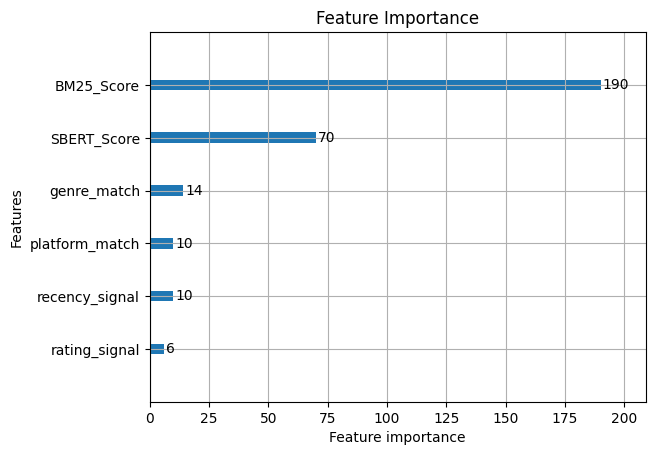

In [3]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20)
plt.title("Feature Importance")
plt.show()


In [7]:
# Load the trained model
model = lgb.Booster(model_file="lambdamart_model.txt")

# Load features to predict on (you already generated this earlier)
df = pd.read_csv("lambdamart_features.csv")

# Define features in the same order as during training
features = [
    "BM25 Score",
    "SBERT Score",
    "rating_signal",
    "popularity_signal",
    "recency_signal",
    "genre_match",
    "platform_match"
]

# Load metadata (title, etc.) from scores.csv
scores_df = pd.read_csv("scores.csv")
meta = scores_df[["ID", "Title", "Genres", "Platforms", "Rating", "Release_Date"]].drop_duplicates()

# Detect query intent and add boost columns
def detect_intent(query):
    query = query.lower()
    return {
        "rating_boost": int(any(kw in query for kw in ["best", "top-rated", "highest rated"])),
        "popularity_boost": int(any(kw in query for kw in ["most played", "popular"])),
        "recency_boost": int(any(kw in query for kw in ["latest", "new", "2025", "2024"]))
    }

# Apply intent detection to each query
intent_df = df["Original Query"].apply(detect_intent).apply(pd.Series)

# Merge intent features into the main df
df = pd.concat([df, intent_df], axis=1)

# Adjust features based on query intent (example: rating_boost, popularity_boost, recency_boost)
df["rating_signal"] = df["rating_signal"] * df["rating_boost"].apply(lambda x: 1.5 if x == 1 else 1)
df["popularity_signal"] = df["popularity_signal"] * df["popularity_boost"].apply(lambda x: 1.5 if x == 1 else 1)
df["recency_signal"] = df["recency_signal"] * df["recency_boost"].apply(lambda x: 1.5 if x == 1 else 1)

# Predict scores using the trained model
df["predicted_score"] = model.predict(df[features])

# Merge metadata (including Release_Date) into df
df = df.merge(meta, on="ID", how="left")

# Sort by predicted score, then by BM25 Score, SBERT Score, and optionally Release Date
ranked_df = df.sort_values(
    ["Original Query", "predicted_score", "BM25 Score", "SBERT Score", "Release_Date"], 
    ascending=[True, False, False, False, True]  # descending for scores, ascending for release date
)

# Drop duplicate game IDs per query
ranked_df = ranked_df.drop_duplicates(subset=["Original Query", "ID"])

# Save top-10 and top-100 per query
top_10 = ranked_df.groupby("Original Query").head(10).reset_index(drop=True)
top_100 = ranked_df.groupby("Original Query").head(100).reset_index(drop=True)

# Save to CSV
top_10.to_csv("top10_ranked_results.csv", index=False)
top_100.to_csv("top100_ranked_results.csv", index=False)

print("✅ Top 10 and Top 100 reranked results saved, with tie-breaking applied.")


✅ Top 10 and Top 100 reranked results saved, with tie-breaking applied.
